# Survival Fraction based on the Cell Cycle and Radiation model

**"Title of paper"**

*Carlos Contreras, Gustavo Carrero and Gerda de Vries*

&copy; Carlos Contreras

## Introduction

In this notebook we find the Survival Fraction of cells after a pulse of radiation based on the effect of radiation on the G2/M transition. The effect of radiation on the G2/M transition will be given by the modell of the cell cycle and the ATM-Chk2 radiation pathway. To compute the average number of lethal DSBs we use a simple linear model for the DSBs separating them in different forms: unrecognized, repairable but remaining, and faulty repairs. Finally we a assume a homogeneous distrubution of cells throughout the cell cycle.

### Julia packages and backends

In [3]:
using OrdinaryDiffEq, ParameterizedFunctions
using Plots, LaTeXStrings
#using JLD

In [4]:
pyplot()

Plots.PyPlotBackend()

## Modules for the cell cycle and radiation combined

The model for the cell cycle and radiation is given by

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3} + k_{m3a} APC)MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)\cdot MPF - (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3}+ k_{m3a} APC)MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25}{J_{c1} + (Cdc25_{T} - Cdc25)}  - (V_{c2}+k_{c2a}Chk2)\frac{Cdc25}{J_{c2} + Cdc25}, \\
\frac{d IE}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE}{J_{i1} + (IE_{T} - IE)} - V_{i2} \frac{IE}{J_{i2} + IE}, \\       
\frac{d APC}{dt}   &= k_{a1}IE \frac{APC_{T} - APC}{J_{a1}+(APC_{T} - APC)} - V_{a2}\frac{APC}{J_{a2}+APC}, \\
\frac{d Mass}{dt}      &= \mu Mass \left( 1 - \frac{Mass}{K_{Mass}} \right),\\
\frac{d Chk2}{dt}  &= k_{h1} ATM \, DSB \frac{Chk2_{T} - Chk2 }{J_{h1} + (Chk2_{T} - Chk2) }  - V_{h2} \frac{Chk2}{J_{h2} + Chk2},\\  
\frac{d ATM}{dt}       &= k_{t1}DSB\frac{ATM_{T}-ATM}{J_{t1}+ATM_{T}-ATM}- V_{t2}\frac{ATM}{J_{t2}+ATM},\\
\frac{d DSB}{dt}       &= k_{d1} \dot D(t) - k_{d2}ATM\,DSB.
\end{align}
where the radiation rate is a pulse at time $t_0$
$$D(t)=D\delta(t-t_0)$$
Numerically, we approximate this with a rectangular window function of size $t_d=1/60$ min
$$D(t)=\frac{D}{t_d}(u(t-t_0)-u(t-(t_0-t_d))),$$
so the radiation scheme is $\frac{D}{t_d}$ Gy per minute for $t_d$ minutes for a total of $D$ Gy.

This model captures the G2/M transition, cell division and radiation pathway.

The first seven equation correspond to the Cell Cycle module, and the last three equations correspond to the Radiation pathway module. The parameters has been chosen to adapt the cell cycle behaviour.

We are interested in finding the survival fraction based on the effect of radiation of the G2/M transition, which will be included in the survival fraction through this model.

**System of ODEs**

In [5]:
f = @ode_def_bare begin
    ## System of ODE (vector field)
    dMPF   = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF
    dMPF_P = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF_P
    dWee1  = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*α)*Wee1/(J_w2 + Wee1)
    dCdc25 = k_c1*(MPF + MPF_P*α)*(Cdc25_T - Cdc25)/(J_c1 + Cdc25_T - Cdc25) - (V_c2+k_c2a*Chk2)*Cdc25/(J_c2 + Cdc25)
    dIE    = k_i1*(MPF + MPF_P*α)*(IE_T - IE)/(J_i1 + IE_T - IE) - V_i2*IE/(J_i2 + IE)
    dAPC   = k_a1*IE*(APC_T - APC)/(J_a1 + APC_T - APC) - V_a2*APC/(J_a2 + APC)
    dMass  = μ*Mass*(1 - Mass/K_Mass)
    dChk2  = k_h1*ATM*DSB*(Chk2_T - Chk2)/(J_h1 + Chk2_T - Chk2) - V_h2*Chk2/(J_h2 + Chk2)
    dATM   = k_t1*DSB*(ATM_T - ATM)/(J_t1 + ATM_T - ATM) - V_t2*ATM/(J_t2 + ATM)
    dDSB   = k_d1*D/t_d*((t_0 <= t <= (t_0 + t_d)) ? 1. : 0.) - k_d2*ATM*DSB
end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 k_c2a J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 k_h1 V_h2 J_h1 J_h2 k_t1 V_t2 J_t1 J_t2 k_d1 k_d2 α μ K_Mass Wee1_T Cdc25_T IE_T APC_T Chk2_T ATM_T θ_M D t_0 t_d;

**Cell division events**

When the concentration of MPF crosses the threshold for mitosis $\theta_M$ from positive to negative, the mass on the cell splits in two. This is forced trhough a callback event.

In [6]:
function division(u,t,integrator)
    # MPF crosses threshold
    u[1] - p.θ_M
end # division

function division_event!(integrator)
    # Divide mass in two
    integrator.u[7] = integrator.u[7]/2
end # division_event!

# Event happens from positive to negative
cb = ContinuousCallback(division, nothing, division_event!, save_positions=(true,false));

**Numerical solution parameters**. The maximum stepsize restriction is required to ensure variables are within the correct values (e.g. APC activitivy is very fast and its concentration increases over 1 when the stepsize is greater than $10^{-2}$).

In [7]:
dtmax = 1e-3
alg = Rosenbrock23();

## Examples

Es an example, we solve the system without radiation and with a radiation pulse for one minute before mitotic entry.

**Initial condition and ODE problem**

In [8]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0);

### No radiation, control case.

**Parameter values**

In [9]:
D = 0.0; t_0 = 0.0
p = (k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2,
    D=D, t_0=t_0, t_d=1/60);

In [10]:
prob = ODEProblem(f, u0, tspan, p)
@time solnorad = solve(prob, alg, callback=cb; dtmax=dtmax)
solnorad.errors

  7.045253 seconds (25.24 M allocations: 1.183 GiB, 7.84% gc time)


### Radiation scheme: pusle of 0.4Gy moments before mitotic entry.

In [11]:
D = .4; t_0 = 2.3
p = (k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2,
    D=D, t_0=t_0, t_d=1/60);

In [12]:
prob = ODEProblem(f, u0, tspan, p)
@time solrad1 = solve(prob, alg, callback=cb; dtmax=dtmax)
solrad1.errors

  0.387714 seconds (2.54 M allocations: 88.180 MiB, 32.92% gc time)


**Plot solutions**

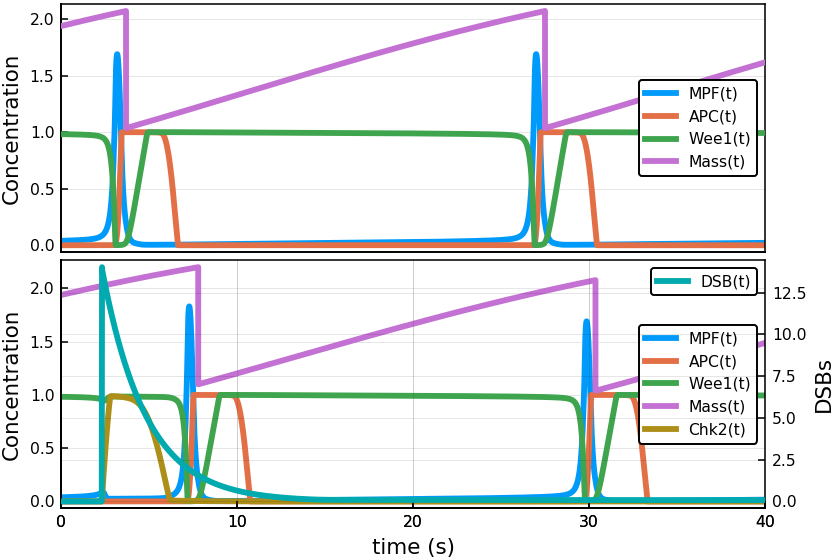

In [13]:
plt1 = plot(solnorad, vars=[:MPF, :APC, :Wee1, :Mass], 
    ylabel="Concentration", xlabel=nothing, xaxis=nothing, border=:box, leg=:right)
plot(solrad1, vars = [:MPF, :APC, :Wee1, :Mass, :Chk2], 
    ylabel="Concentration", xlabel="time (s)", leg=:right)
plt = twinx()
plt2 = plot!(plt, solrad1, vars=[:DSB], 
    color=6, leg = :topright, ylabel="DSBs", xlabel=nothing, border=:box)
plot(plt1, plt2, layout=@layout([a; b{0.95w}]), dpi=140)

The plot shows one full cell cycle. During interphase, the concentration of active MPF is low and Wee1 is fully active; but as the concentration of MPF increases as a result of cell growth, the activity of MPF reaches the threshold for mitosis $\theta_M=0.2$, and the cell enters mitosis. During M-phase, Wee1 becomes inactive, the concentration of MPF increases and decreases as APC becomes active. Right after the MPF concentration decreases to $\theta_M=0.2$, the cel division event divides the cell mass in two.

Mitotic entry is delayed (around 15 h) after induced radiation. Radiation dose is low but sufficiently high to delay mitosis.

We are interested in finding the available time for repair after radiation has been applied. This time changes depending on the moment of radiation $t_0$ and radiation intensity $D$.

## Time available for repair

To find the time available for repair we change the callback function to stop at M-phase entry

In [14]:
function Mphase(u,t,integrator)
    # MPF crosses threshold
    u[1] - p.θ_M
end # division

function Mphase_event!(integrator)
    # Stop integration at mitotic entry
    terminate!(integrator)
end # division_event!

# Event happens from positive to negative
cb2 = ContinuousCallback(Mphase, Mphase_event!, nothing, save_positions=(true,false));

We define initial conditions exactly at the start of the cell cycle. To find initial condition we can the system with similar callback function but with a "end of M-phase" event (steps not shown here).

In [15]:
u0 = [0.2000,      # MPF
      0.0120,      # MPF_P
      0.0253,      # Wee1
      0.9782,      # Cdc25_P
      0.9925,      # IE_A
      0.9997,      # APC_A
      1.0353,      # Mass
      0.0000,      # Chk2_P
      0.0000,      # ATM
      0.0000]      # DSB
tspan2 = (0.0, Inf)
# No radiation
D = .0; t_0 = .0
p = (k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2,
    D=D, t_0=t_0, t_d=1/60);
prob = ODEProblem(f, u0, tspan2, p);
@time solnorad = solve(prob, alg, callback=cb2; dtmax=dtmax)
# Radiation
D = .4; t_0 = 22.
p = (k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2,
    D=D, t_0=t_0, t_d=1/60);
prob = ODEProblem(f, u0, tspan2, p);
@time solrad1 = solve(prob, alg, callback=cb2; dtmax=dtmax);

  1.833878 seconds (4.54 M allocations: 193.403 MiB, 4.39% gc time)
  0.294136 seconds (1.94 M allocations: 61.984 MiB, 40.05% gc time)


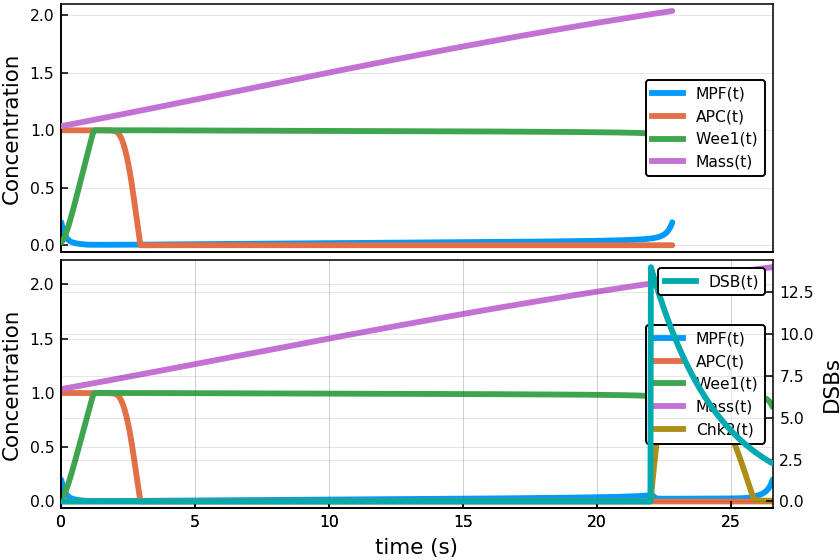

In [16]:
plt1 = plot(solnorad, vars = [:MPF, :APC, :Wee1, :Mass], 
    xlabel=nothing, xaxis=nothing, xlims=extrema(solrad1.t),
    ylabel="Concentration", border=:box, leg=:right)
plot(solrad1, vars = [:MPF, :APC, :Wee1, :Mass, :Chk2], 
    xlabel="time (s)", ylabel="Concentration", leg=:right)
plt = twinx()
plt2 = plot!(plt, solrad1, vars = [:DSB], 
    color=6, leg = :topright, xlabel=nothing, ylabel="DSBs", border=:box)
plot(plt1, plt2, layout = @layout([a; b{0.95w}]), dpi = 140)

Hence, the time avaliable for repair from $t_0$ until the moment of M-phase entry is

In [17]:
solrad1.t[end] - t_0

4.560443659228749

Note that the length of the cell cycle $T$ in the no radiation case is

In [18]:
T = solnorad.t[end]

22.816764277344546

In order to find the the time available for repair for different values of $t_0$ and $D$ we preferably enclose some line in a function.

In [19]:
function TimeAvailableForRepair(t_0, D)
    p = (k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
        V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
        k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
        k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, 
        k_d1=35.00, k_d2=0.4, α=0.05, μ=0.07, K_Mass=2.7, 
        Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2,
        D=D, t_0=t_0, t_d=1/60);

    # Solve one time without radiation
    prob = ODEProblem(f, u0, tspan, p)
    sol = solve(prob, alg, callback=cb2; dtmax=dtmax)
    sol.t[end] - t_0
end

TimeAvailableForRepair (generic function with 1 method)

Find a contour plot for the of the time available for repair for several values of time of radiation $t_0$ and total dose $D$.

In [20]:
DD = [0.0:0.01:1.0;]
tt_0 = [0.0:1.0:20.0; 20.01:0.01:22.60; 22.601:0.001:T;]
@time t_r = p.k_d2*[TimeAvailableForRepair(t_0, D) for t_0 in tt_0, D in DD];

10105.622205 seconds (93.68 G allocations: 2.853 TiB, 21.79% gc time)


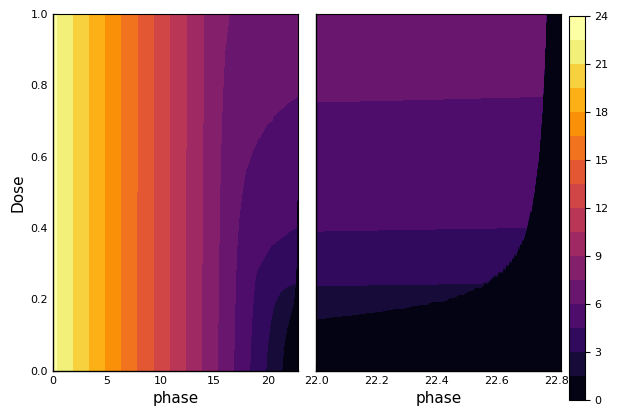

In [92]:
pt1 = contourf(tt_0, DD, 2.5*t_r', 
    xlims=extrema(tt_0), xlabel="phase", ylabel="Dose", colorbar=nothing)
pt2 = contourf(tt_0, DD, 2.5*t_r', 
    xlims=(22., maximum(tt_0)), xlabel="phase", ylabel=nothing, yaxis=nothing)
plot(pt1, pt2, layout=(1, 2), border=:box)
savefig("./FigSimulationTimeAvailableRepair.pdf")

To find the average number of DSBs
$$\lambda_{mc}(D) = \nu \frac{1}{T} \left( \int_{0}^{T}e^{-t_r(t_0, D)}f(t_0)dt_0 \right) D$$
we can find the integral using the [trapezoid rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)
$$I= \int_{a}^{b} g(t)dt = \sum_{n=0}^{N}\frac{g(t^{i-1})+g(t^{i})}{2}(t^{i}-t^{i-1})$$
where $\{t^i\}_{i=0}^{N}$ is the discretization of $t$, and $t^0=a\leq t\leq b=t^N$.

In [22]:
function trap(x::Vector, y::Vector)
    I = 0.
    for i in 2:length(y)
        I += (y[i] + y[i-1])/2*(x[i] - x[i-1])
    end
    I
end

trap (generic function with 1 method)

#### Homogeneous distribution

Let's assume a homogeneous (uniform) distrubution
$$f(t)=\frac{1}{T}.$$

In [93]:
T = solnorad.t[end]
dist_unif(t) = 1/T
I = [1/T*trap(tt_0, exp.(-2.5*t_r'[i,:]).*dist_unif.(tt_0)) for i in 1:length(DD)];

Thus, the average number of lethal event under mitotic catastrophe follows $\lambda_{mc}(D)$ is

In [94]:
ν = p.k_d1 #NOTE: THIS DOESN'T MATCH μ SHOULD BE 35.
λ_mc = ν*I.*DD;

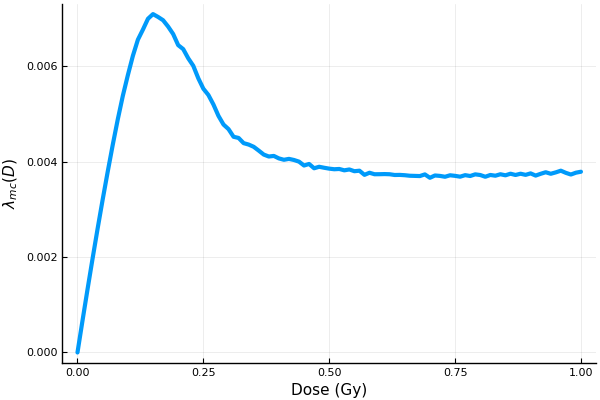

In [95]:
plot(DD, λ_mc, w=3, 
    xaxis=("Dose (Gy)"), yaxis=(L"$\lambda_{mc}(D)$"), leg=false)

The surival fraction is given by
$$S(D) = e^{-\lambda_{mc}(D)-(\alpha D + \beta D^2)},$$
where $\alpha D$ and $\beta D^2$ are the basal linear and quadratic terms not involved with the G2/M transition.

In [96]:
α = 0.2
β = 0.08
SS = exp.(-λ_mc -(α*DD + β*DD.^2));

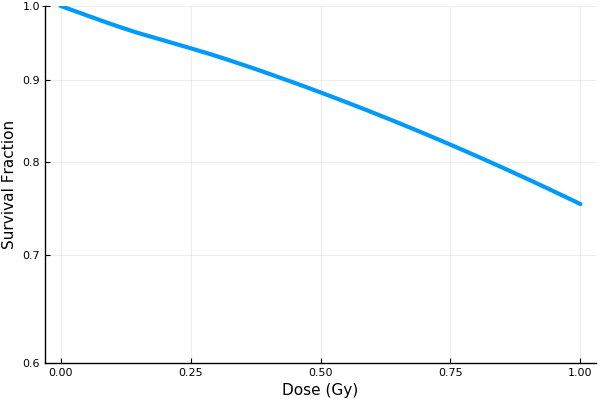

In [97]:
plot(DD, SS, w=3, 
    xaxis=("Dose (Gy)"), yaxis=("Survival Fraction", :log10, (0.6, 1.0)), leg=false)
tks = [0.6:0.1:1.0;]
yticks!(tks, map(string,tks))

### Von Mises distribution

Now, we assume a [Von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution) of the cell cycle
$$f(t|\mu, \kappa)=\frac{e^{\kappa\cos(x-\mu)}}{2\pi I_0(\kappa)}$$
where $I_0(\kappa)$ is the modified Bessel function of order 0. The Von Mises distribution allow us to simulate cells rich in G2-phase. We redefine the domain of the Von Mises distibution to account for the legth of the cell cycle $T$ using the transformation
$$x - \mu \mapsto \frac{2\pi(x-\mu)}{T}$$

In [98]:
using SpecialFunctions
vonmisses(x, μ, κ) = exp(κ*cos(x-μ))/(2*pi*besseli(0, κ))

vonmisses (generic function with 1 method)

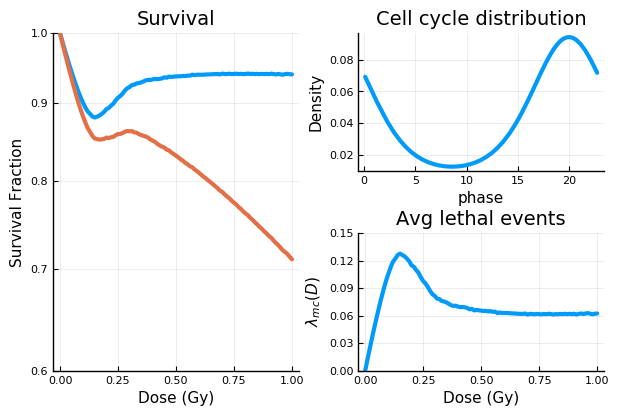

In [108]:
#
T = solnorad.t[end]
ν = 10*p.k_d1 #NOTE: THIS DOESN'T MATCH μ SHOULD BE 35.0 only
# scalling factor to fit peridiocity of distribution cell cycle length period
a = 2pi/T
dist_vonmises(x) = a*vonmisses(a*x, a*20., 1.)
# integration
I = [1/T*trap(tt_0, exp.(-2.5*t_r'[i,:]).*dist_vonmises.(tt_0)) for i in 1:length(DD)];
λ_mc = ν*I.*DD
# survival fraction (mitotic catastrophe only)
SS = exp.(-λ_mc);
# survival fraction (extra terms)
α = 0.2
β = 0.08
SS2 = exp.(-λ_mc -(α*DD + β*DD.^2))
# plotting
pt1 = plot(dist_vonmises, 0, T, 
    w=3, leg = false, xaxis=("phase"), yaxis=("Density"), title="Cell cycle distribution")
pt2 = plot(DD, λ_mc, w=3, 
    xaxis=("Dose (Gy)"), yaxis=(L"$\lambda_{mc}(D)$", (0, 0.15)), leg=false, title="Avg lethal events")
pt3 = plot(DD, [SS, SS2], w=3, 
    xaxis=("Dose (Gy)"), yaxis=("Survival Fraction", :log10, (0.6, 1.0)), leg=false, title="Survival")
tks = [0.6:0.1:1.0;]
yticks!(tks, map(string,tks))
plot(pt3, pt1, pt2, layout = @layout([a [b; c]]))
savefig("./FigSurvivalFaction.pdf")

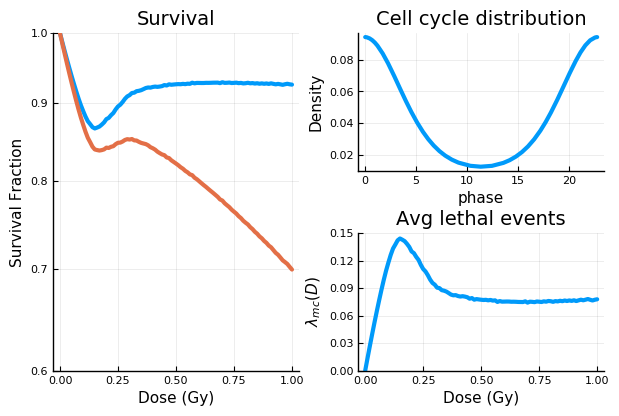

┌ Info: Saved animation to 
│   fn = /home/carlos/Documents/Academic/Research/15-Cell_survival/Manuscripts/18-01 Cell Fate Mechanisms/codes/GifSurvivalFraction.gif
└ @ Plots /home/carlos/.julia/packages/Plots/7o1Vu/src/animation.jl:90


Plots.AnimatedGif("/home/carlos/Documents/Academic/Research/15-Cell_survival/Manuscripts/18-01 Cell Fate Mechanisms/codes/GifSurvivalFraction.gif")

In [109]:
# parameters
T = solnorad.t[end]
ν = 10*p.k_d1 #NOTE: THIS DOESN'T MATCH μ SHOULD BE 35.0 only
# scalling factor to fit peridiocity of distribution cell cycle length period
a = 2pi/T
anim = @animate for mean in range(0.0, stop=T, length=100)
    # distribution
    dist_vonmises(x) = a*vonmisses(a*x, a*mean, 1.)
    # integration
    I = [1/T*trap(tt_0, exp.(-2.5*t_r'[i,:]).*dist_vonmises.(tt_0)) for i in 1:length(DD)];
    λ_mc = ν*I.*DD
    # survival fraction (mitotic catastrophe only)
    SS = exp.(-λ_mc);
    # survival fraction (extra terms)
    α = 0.2
    β = 0.08
    SS2 = exp.(-λ_mc -(α*DD + β*DD.^2))
    # plotting
    pt1 = plot(dist_vonmises, 0, T, 
        w=3, leg = false, xaxis=("phase"), yaxis=("Density"), title="Cell cycle distribution")
    pt2 = plot(DD, λ_mc, w=3, 
        xaxis=("Dose (Gy)"), yaxis=(L"$\lambda_{mc}(D)$", (0, 0.15)), leg=false, title="Avg lethal events")
    pt3 = plot(DD, [SS, SS2], w=3, 
        xaxis=("Dose (Gy)"), yaxis=("Survival Fraction", :log10, (0.6, 1.0)), leg=false, title="Survival")
    tks = [0.6:0.1:1.0;]
    yticks!(tks, map(string,tks))
    plot(pt3, pt1, pt2, layout = @layout([a [b; c]]))
end
gif(anim, "./GifSurvivalFraction.gif", fps=10)

In [ ]:
# T = solnorad.t[end]
# pp = 1.0 
# qq = 0.99
# μ = .5 #p.k_d1/(pp*qq) !THIS DOESN'T MATCH μ SHOULD BE 35.
# GK(v1, v2, J1, J2) = 2*J2*v1/v2/(1 - v1/v2 + J1 + J2*v1/v2 + sqrt((1 - v1/v2 + J1 + J2*v1/v2)^2 - 4*J2*(1-v1/v2)*v1/v2))
# ϕ(D) = GK(p.k_h1*p.k_d1*D, p.V_h2, p.J_h1, p.J_h2)
# a = 2pi/T # scalling to fit cell cycle length period
# f_dist(x) = a*vonmisses(a*x, a*10., 3.)
# I = [1/T*trap(tt_0, exp.(-t_r'[i,:]).*f_dist.(tt_0)) for i in 1:length(DD)];
# λ_mc = (1.0 .- qq*ϕ.(DD) + (1-pp)*qq*(exp(p.k_d2*T)-1)/(p.k_d2*T)*ϕ.(DD) + pp*qq*ϕ.(DD).*I)*μ.*DD;
# SS = exp.(-λ_mc);
# SS2 = exp.(-λ_mc -(α*DD + β*DD.^2));
# pt1 = plot(f_dist, 0, T, 
#     w=3, leg = false, xaxis=("phase"), yaxis=("Density"), title="Cell cycle distribution")
# pt2 = plot(DD, λ_mc, w=3, 
#     xaxis=("Dose (Gy)"), yaxis=(L"$\lambda_{mc}(D)$"), leg=false, title="Avg lethal events")
# pt3 = plot(DD, [SS, SS2], w=3, 
#     xaxis=("Dose (Gy)"), yaxis=("Survival Fraction", :log10, (0.6, 1.0)), leg=false, title="Survival")
# tks = [0.6:0.1:1.0;]
# yticks!(tks, map(string,tks))
# plot(pt3, pt1, pt2, layout = @layout([a [b; c]]))